<a href="https://colab.research.google.com/github/JINYUHOON/VIS_temp/blob/main/08_MultiClass_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow import keras

In [ ]:
import tensorflow_hub as hub

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/classification/2",trainable=True),
    layers.Dense(37, activation='softmax')
])
model.build([None, 256, 256, 3])  # Batch input shape.

adam = keras.optimizers.Adam(lr=0.0001)

model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 21843)             33900195  
                                                                 
 dense_1 (Dense)             (None, 37)                808228    
                                                                 
Total params: 34,708,423
Trainable params: 34,647,815
Non-trainable params: 60,608
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from albumentations.augmentations.transforms import ShiftScaleRotate
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode =='train':
            self.transform = A.Compose([
                                   A.HorizontalFlip(p=0.5),
                                   A.ShiftScaleRotate(
                                       p = 0.5,
                                       shift_limit = 0.05,
                                       scale_limit = 0.05,
                                       rotate_limit = 15,
                                   ),
                                #    A.CoarseDropout(
                                #        p=0.5,
                                #        max_holes = 8,
                                #        max_height = int( 0.1 * size),
                                #        max_width = int( 0.1 * size)    
                                #    ),
                                   A.RandomBrightnessContrast(p=0.2),
            ])
    

    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [ ]:
base_path = '/content/drive/MyDrive/HOON/exam/OX/data/'
csv_path = base_path + 'kfolds.csv'

pd.read_csv(csv_path)

,file_name,id,species,bread,fold
0,Abyssinian_100,1,1,1,2
1,Abyssinian_101,1,1,1,3
2,Abyssinian_102,1,1,1,1
3,Abyssinian_103,1,1,1,4
4,Abyssinian_104,1,1,1,4
...,...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25,5
7345,yorkshire_terrier_97,37,2,25,1
7346,yorkshire_terrier_98,37,2,25,3
7347,yorkshire_terrier_99,37,2,25,5


In [ ]:
base_path = '/content/drive/MyDrive/HOON/exam/OX/data/'
import math

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.mode = mode
        self.image_size = image_size
        self.shuffle = shuffle

        self.df = pd.read_csv(csv_path)

        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode =='val':
            self.df = self.df[self.df['fold'] == self.fold]

        # Remove invalid
        invalid_filenames = [
                             'Egyptian_Mau_14',
                             'Egyptian_Mau_139',
                             'Egyptian_Mau_145',
                             'Egyptian_Mau_156',
                             'Egyptian_Mau_167',
                             'Egyptian_Mau_177',
                             'Egyptian_Mau_186',
                             'Egyptian_Mau_1191',
                             'Abyssinian_5',
                             'Abyssinian_34',
                             'chihuahua_121',
                             'beagle_116'
                             
        ]

        self.df = self.df[-self.df['file_name'].isin(invalid_filenames)]
        self.transform = Augmentation(image_size , mode)

        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx+1) * self.batch_size
        data = self.df.iloc[strt:fin]

        batch_x, batch_y = self.get_data(data)

        return np.array(batch_x), np.array(batch_y)

    def get_data(self, data):
        batch_x = []
        batch_y = []

        for _ , r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(base_path + f'images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image , (self.image_size , self.image_size))

            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)

            image = image.astype('float32')
            image = image / 255.

            label = int(r['id']-1)

            batch_x.append(image)
            batch_y.append(label)

        return batch_x, batch_y

    def on_epoch_end(self):

        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

csv_path = base_path + 'kfolds.csv'

train_generator = DataGenerator(batch_size = 64, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 256,
                                mode='train', 
                                shuffle=True)

valid_generator = DataGenerator(batch_size = 64, 
                                csv_path=csv_path, fold = 1, 
                                image_size = 256,
                                mode='val', 
                                shuffle=True)

In [ ]:
history = model.fit(train_generator , validation_data = valid_generator,
                    epochs = 10, verbose = 1)

Epoch 1/10
85/92 [==========================>...] - ETA: 1:45 - loss: 42.1704 - accuracy: 0.1106

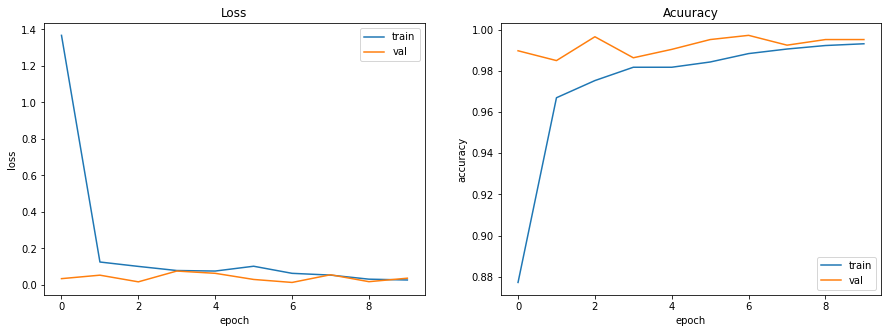

In [ ]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss')

plt.subplot(122)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Acuuracy')

plt.show()